<a href="https://colab.research.google.com/github/farhanwadia/mie443_contest3/blob/Henry/MIE443_Final_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall --y torch

Uninstalling torch-1.8.1+cu101:
  Successfully uninstalled torch-1.8.1+cu101


In [2]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 44.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [3]:
import torch
print(torch.__version__)

1.4.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -q '/content/drive/My Drive/UofT/Fourth Year/MIE443/train_split.zip'

In [7]:
import torch
import torch.nn as nn
import argparse
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, models
from sklearn.model_selection import KFold

#Support Functions

###Input Args

In [8]:
def getInputArgs():
    parser = argparse.ArgumentParser('Sample for training an emotion classification model.')
    parser.add_argument('--gpu', dest='gpu', default=torch.cuda.is_available(), type=bool, help='Use gpu for training')
    parser.add_argument('--nepoch', dest='nepoch', default=10, type=int, help='Number of training epochs')
    parser.add_argument('--mdl', dest='mdl', default=None, type=str, help='Model to load')
    parser.add_argument('--val', dest='val', action='store_true', help='Get validation score')
    parser.add_argument('-f')
    args = parser.parse_args()
    return args

###Data Loader

In [9]:
def getDataloader(all_imgs, all_labels, train_ids, test_ids, batch_size = 128):
    
    train_imgs = all_imgs[train_ids]
    train_labels = all_labels[train_ids]
    val_imgs = all_imgs[test_ids]
    val_labels = all_labels[test_ids]

    train_dataset = torch.utils.data.TensorDataset(*(train_imgs, train_labels))
    val_dataset = torch.utils.data.TensorDataset(*(val_imgs, val_labels))

    # Due to class imbalance introduce a weighted random sampler to select rare classes more often.
    weights_label = train_labels.unique(return_counts=True, sorted=True)[1].float().reciprocal()
    weights = torch.zeros_like(train_labels, dtype=torch.float)
    for idx, label in enumerate(train_labels):
        weights[idx] = weights_label[label]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    # Create the dataloaders for the different datasets.
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            num_workers=2, sampler=sampler,)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    return train_loader, val_loader

###Get acc

In [10]:
def calc_acc(mdl, dl, dl_type, device):
    print('')
    with torch.no_grad():
        pbar = tqdm(dynamic_ncols=True, total=int(len(dl)))
        total = 0
        ncorrect = 0
        for nex, ex in enumerate(dl):
            ims, labels, = ex
            ims = ims.to(device)
            labels = labels.to(device)
            predicted = mdl(ims, True)
            total += labels.size(0)
            ncorrect += (predicted == labels).sum().item()
            status = '%s ACC: %.4f '%(dl_type, float(ncorrect) / total)
            pbar.set_description(status)
            pbar.update(1)
    pbar.close()
    return float(ncorrect) / total

###Get acc - no bar

In [15]:
def calc_acc(mdl, dl, dl_type, device):
    #print('')
    with torch.no_grad():
        #pbar = tqdm(dynamic_ncols=True, total=int(len(dl)))
        total = 0
        ncorrect = 0
        for nex, ex in enumerate(dl):
            ims, labels, = ex
            ims = ims.to(device)
            labels = labels.to(device)
            predicted = mdl(ims, True)
            total += labels.size(0)
            ncorrect += (predicted == labels).sum().item()
            status = '%s ACC: %.4f '%(dl_type, float(ncorrect) / total)
            #pbar.set_description(status)
            #pbar.update(1)
    #pbar.close()
    return float(ncorrect) / total

###Reset Weights

In [12]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

###Regular Training

In [13]:
def train_loop(mdl, loss_fn, optim, dl, device):
    #print('')
    #pbar = tqdm(dynamic_ncols=True, total=int(len(dl)))
    n_batch_loss = 50
    running_loss = 0
    for nex, ex in enumerate(dl):
        ims, labels, = ex
        ims = ims.to(device)
        labels = labels.to(device)
        #
        # Optimization.
        optim.zero_grad()
        outs = mdl(ims)
        loss = loss_fn(outs, labels)
        loss.backward(loss)
        optim.step()
        #
        # Statistics
        running_loss +=  loss.item()
        nex += 1
        if nex % n_batch_loss == 0:
            status = 'L: %.4f '%(loss / n_batch_loss)
            avg_loss = (loss / n_batch_loss)
            running_loss = 0
            #pbar.set_description(status)
        #pbar.update(1)
    #pbar.close()
    return mdl, avg_loss

###Train with transforms

In [ ]:
transforms.RandomAdjustSharpness(0.25, p=0.5)

In [14]:
def train_loop_t(mdl, loss_fn, optim, dl, device):
    #print('')
    train_transform = transforms.Compose([transforms.ToPILImage(),
                                          transforms.RandomHorizontalFlip(p=0.25),
                                          transforms.RandomRotation(15),
                                          transforms.RandomPerspective(distortion_scale=0.1,p=0.25),
                                          transforms.ToTensor()])
    #pbar = tqdm(dynamic_ncols=True, total=int(len(dl)))
    n_batch_loss = 50
    running_loss = 0
    for nex, ex in enumerate(dl):
        ims, labels, = ex
        ims = ims.to(device)
        for i in range(len(ims)):
          ims[i] = train_transform(ims[i])
        labels = labels.to(device)
        #
        # Optimization.
        optim.zero_grad()
        outs = mdl(ims)
        loss = loss_fn(outs, labels)
        loss.backward(loss)
        optim.step()
        #
        # Statistics
        running_loss +=  loss.item()
        nex += 1
        if nex % n_batch_loss == 0:
            status = 'L: %.4f '%(loss / n_batch_loss)
            avg_loss = (loss / n_batch_loss)
            running_loss = 0
            #pbar.set_description(status)
        #pbar.update(1)
    #pbar.close()
    return mdl, avg_loss

#Models

###Baseline Model

In [16]:
class EmotionClassificationNet(nn.Module):

    def __init__(self):
        super(EmotionClassificationNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
        )
        self.nn = nn.Sequential(
            nn.Linear(1152, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 7)

        )

    def forward(self, x, test_mode=False):
        batch_size = x.shape[0]
        feats = self.cnn(x)
        out = self.nn(feats.view(batch_size, -1))
        #
        # If we are testing then return prediction index.
        if test_mode:
            _, out = torch.max(out, 1)
        return out

###Improved Model

In [31]:
class EmotionClassificationNet_Better(nn.Module):

    def __init__(self, dropout=0.25):
        super(EmotionClassificationNet_Better, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
        )
        self.nn = nn.Sequential(
            nn.Linear(1152*2,512),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 7)
        )

    def forward(self, x, test_mode=False):
        batch_size = x.shape[0]
        feats = self.cnn(x)
        out = self.nn(feats.view(batch_size, -1))
        #
        # If we are testing then return prediction index.
        if test_mode:
            _, out = torch.max(out, 1)
        return out

# Baseline Training


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
--------------------------------

 FOLD 1
--------------------------------
Epoch: 0 | Training Acc: 0.48588335396039606 | Validation acc: 0.4344934261407579
Epoch: 1 | Training Acc: 0.5612237004950495 | Validation acc: 0.4860015467904099
Epoch: 2 | Training Acc: 0.6162592821782178 | Validation acc: 0.5297757153905646
Epoch: 3 | Training Acc: 0.6425201113861386 | Validation acc: 0.5395204949729312
Epoch: 4 | Training Acc: 0.6673112623762376 | Validation acc: 0.5625676720804331
Epoch: 5 | Training Acc: 0.676980198019802 | Validation acc: 0.5559164733178654
Epoch: 6 | Training Acc: 0.7047493811881188 | Validation acc: 0.5767981438515081
Epoch: 7 | Training Acc: 0.7279935024752475 | Validation acc: 0.5860788863109049
Epoch: 8 | Training Acc: 0.7418007425742574 | Validation acc: 0.5866976024748647
Epoch: 9 | Training Acc: 0.758121905940594 | Validation acc: 0.5955143078112916


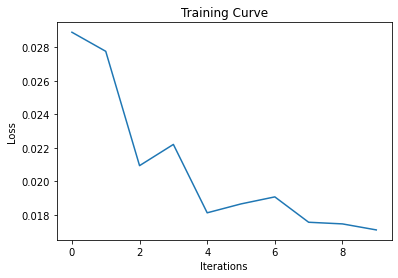

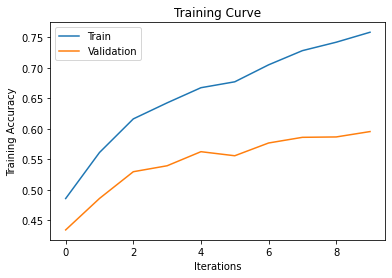

Final Training Accuracy: 0.758121905940594
Final Validation Accuracy: 0.5955143078112916

 FOLD 2
--------------------------------
Epoch: 0 | Training Acc: 0.453030127238272 | Validation acc: 0.3875309405940594
Epoch: 1 | Training Acc: 0.5385775612019956 | Validation acc: 0.4723081683168317
Epoch: 2 | Training Acc: 0.5664616931585258 | Validation acc: 0.4873143564356436
Epoch: 3 | Training Acc: 0.603395598870712 | Validation acc: 0.49969059405940597
Epoch: 4 | Training Acc: 0.6277603743667092 | Validation acc: 0.5185643564356436
Epoch: 5 | Training Acc: 0.6399814363615268 | Validation acc: 0.5250618811881188
Epoch: 6 | Training Acc: 0.6516610589008779 | Validation acc: 0.5245977722772277
Epoch: 7 | Training Acc: 0.6354565494836988 | Validation acc: 0.5213490099009901
Epoch: 8 | Training Acc: 0.6626832192443052 | Validation acc: 0.5346534653465347
Epoch: 9 | Training Acc: 0.676799319333256 | Validation acc: 0.5498143564356436


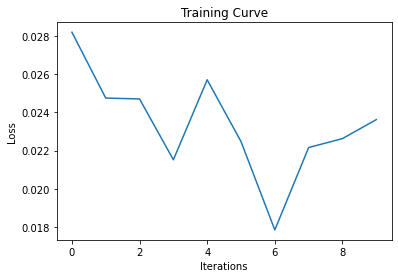

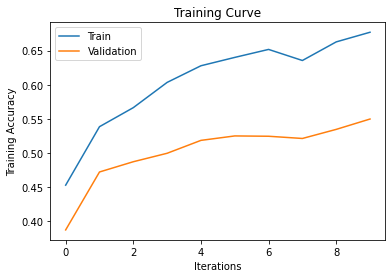

Final Training Accuracy: 0.676799319333256
Final Validation Accuracy: 0.5498143564356436

 FOLD 3
--------------------------------
Epoch: 0 | Training Acc: 0.437792473991569 | Validation acc: 0.3771658415841584
Epoch: 1 | Training Acc: 0.5245001353598638 | Validation acc: 0.45126856435643564
Epoch: 2 | Training Acc: 0.5744672622500677 | Validation acc: 0.5035581683168316
Epoch: 3 | Training Acc: 0.6300808291758518 | Validation acc: 0.5399133663366337
Epoch: 4 | Training Acc: 0.6554898093359632 | Validation acc: 0.5389851485148515
Epoch: 5 | Training Acc: 0.6708821595699423 | Validation acc: 0.5539913366336634
Epoch: 6 | Training Acc: 0.6846501914375217 | Validation acc: 0.5615717821782178
Epoch: 7 | Training Acc: 0.6978767838496345 | Validation acc: 0.5689975247524752
Epoch: 8 | Training Acc: 0.7177553467146227 | Validation acc: 0.583075495049505
Epoch: 9 | Training Acc: 0.7308659163862784 | Validation acc: 0.573019801980198


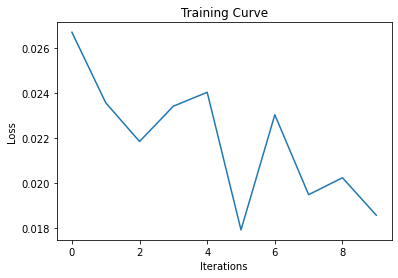

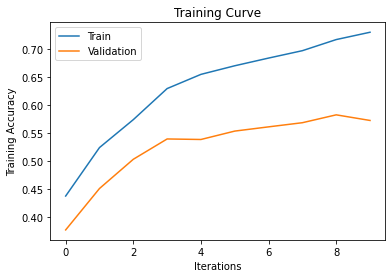

Final Training Accuracy: 0.7308659163862784
Final Validation Accuracy: 0.573019801980198

 FOLD 4
--------------------------------
Epoch: 0 | Training Acc: 0.4724059248946127 | Validation acc: 0.416615099009901
Epoch: 1 | Training Acc: 0.5611633213443168 | Validation acc: 0.4916460396039604
Epoch: 2 | Training Acc: 0.5880805971303709 | Validation acc: 0.49566831683168316
Epoch: 3 | Training Acc: 0.6259426847662142 | Validation acc: 0.5502784653465347
Epoch: 4 | Training Acc: 0.650848899717678 | Validation acc: 0.5556930693069307
Epoch: 5 | Training Acc: 0.668755075994895 | Validation acc: 0.5595606435643564
Epoch: 6 | Training Acc: 0.692075646826778 | Validation acc: 0.5742574257425742
Epoch: 7 | Training Acc: 0.689329775302626 | Validation acc: 0.5651299504950495
Epoch: 8 | Training Acc: 0.6869319719998453 | Validation acc: 0.5775061881188119
Epoch: 9 | Training Acc: 0.709943148857176 | Validation acc: 0.5788985148514851


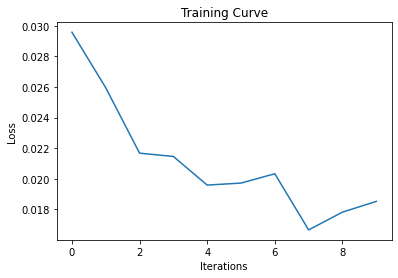

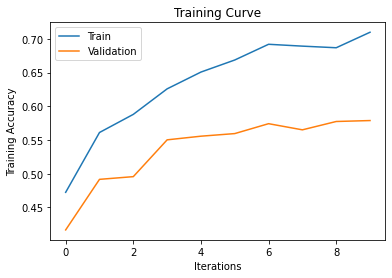

Final Training Accuracy: 0.709943148857176
Final Validation Accuracy: 0.5788985148514851

 FOLD 5
--------------------------------
Epoch: 0 | Training Acc: 0.46683683335267045 | Validation acc: 0.4190903465346535
Epoch: 1 | Training Acc: 0.5596550257183741 | Validation acc: 0.4964418316831683
Epoch: 2 | Training Acc: 0.6026221139343312 | Validation acc: 0.5252165841584159
Epoch: 3 | Training Acc: 0.620373593224272 | Validation acc: 0.5204207920792079
Epoch: 4 | Training Acc: 0.6382410952546699 | Validation acc: 0.5396039603960396
Epoch: 5 | Training Acc: 0.6550643926209537 | Validation acc: 0.5505878712871287
Epoch: 6 | Training Acc: 0.6628379162315814 | Validation acc: 0.5592512376237624
Epoch: 7 | Training Acc: 0.6944347758827397 | Validation acc: 0.5761138613861386
Epoch: 8 | Training Acc: 0.691959624086321 | Validation acc: 0.5648205445544554
Epoch: 9 | Training Acc: 0.7020922767529102 | Validation acc: 0.5646658415841584


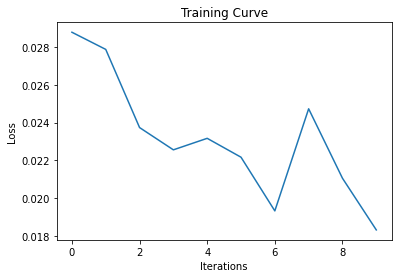

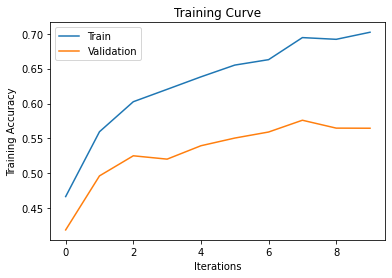

Final Training Accuracy: 0.7020922767529102
Final Validation Accuracy: 0.5646658415841584

 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 1: 0.5955143078112916 %
Fold 2: 0.5498143564356436 %
Fold 3: 0.583075495049505 %
Fold 4: 0.5788985148514851 %
Fold 5: 0.5761138613861386 %

 Average Cross-Validation Accuracy: 0.5766833071068127 %


In [ ]:
if __name__ == "__main__": 
    %%time
    results = {}
    torch.manual_seed(42)
    k_folds = 5
    all_imgs, all_labels = torch.load('train_split.pth')
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # Start print
    print('--------------------------------')

    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_imgs)):

        # Print
        print('\n', f'FOLD {int(fold)+1}')
        print('--------------------------------')
        
        args = getInputArgs()
        args.nepoch = 10
        train_dl, val_dl = getDataloader(all_imgs, all_labels, train_ids, test_ids, batch_size = 128)
        mdl = EmotionClassificationNet()
        mdl.apply(weight_reset) #Reset weights for proper training
        ce_loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(mdl.parameters())
        #optimizer = torch.optim.Adam(mdl.parameters(),weight_decay=1e-8,lr=0.0001)
        #optimizer = torch.optim.SGD(mdl.parameters(),momentum=0.9,weight_decay=1e-7,lr=0.001)
        device = torch.device('cpu')
        iters, losses, train_acc_list, val_acc_list = [], [], [], []
        #args.val = True #Toggle validation mode
        #args.mdl = '/content/mdl_best.pth'
        if args.gpu:
            device = torch.device('cuda:0')
        if args.mdl is not None:
            mdl.load_state_dict(torch.load(args.mdl))
        mdl = mdl.to(device)
        if args.val:
            print('Val ACC loop')
            mdl.train(False)
            val_acc = calc_acc(mdl, val_dl, 'val', device)
            print('VAL ACC: ', val_acc)
        else:
            #
            # Training loop.
            best_val = -float('inf')
            for epoch in range(args.nepoch):
                #print('Train loop: ', str(epoch))
                mdl.train(True)
                mdl, avg_loss = train_loop(mdl, ce_loss, optimizer, train_dl, device)
                #print('Train ACC loop: ',str(epoch))
                mdl.train(False)
                train_acc = calc_acc(mdl, train_dl, 'train', device)
                #print('Val ACC loop: ',str(epoch))
                val_acc = calc_acc(mdl, val_dl, 'val', device)
                print('Epoch: {} | Training Acc: {} | Validation acc: {}'.format(str(epoch),train_acc,val_acc))

                #Plotting vars
                iters.append(epoch)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
                losses.append(avg_loss)
                #
                # Early stopping.
                if val_acc > best_val:
                    best_val = val_acc
                    torch.save(mdl.state_dict(), 'mdl_best.pth')
            
            #Plotting
            plt.title("Training Curve")
            plt.plot(iters, losses, label="Train")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.show()

            plt.title("Training Curve")
            plt.plot(iters, train_acc_list, label="Train")
            plt.plot(iters, val_acc_list, label="Validation")
            plt.xlabel("Iterations")
            plt.ylabel("Training Accuracy")
            plt.legend(loc='best')
            plt.show()
            
            print("Final Training Accuracy: {}".format(train_acc_list[-1]))
            print("Final Validation Accuracy: {}".format(val_acc_list[-1]))
            results[fold] = best_val

    # Print fold results
    print('\n',f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
      print(f'Fold {int(key)+1}: {value} %')
      sum += value
    print('\n',f'Average Cross-Validation Accuracy: {sum/len(results.items())} %')

#Improved Training

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
--------------------------------

 FOLD 1
--------------------------------
Epoch: 0 | Training Acc: 0.41889696782178215 | Validation acc: 0.39350348027842225
Epoch: 1 | Training Acc: 0.5031714108910891 | Validation acc: 0.4281515854601701
Epoch: 2 | Training Acc: 0.5559637995049505 | Validation acc: 0.48491879350348027
Epoch: 3 | Training Acc: 0.5874845297029703 | Validation acc: 0.51446249033256
Epoch: 4 | Training Acc: 0.587136448019802 | Validation acc: 0.5221964423820572
Epoch: 5 | Training Acc: 0.6312267945544554 | Validation acc: 0.5436968290796597
Epoch: 6 | Training Acc: 0.6383044554455446 | Validation acc: 0.5495746326372777
Epoch: 7 | Training Acc: 0.6333539603960396 | Validation acc: 0.5497293116782676
Epoch: 8 | Training Acc: 0.6825881806930693 | Validation acc: 0.5750966744006187
Epoch: 9 | Training Acc: 0.6773282797029703 | Validation acc: 0.5760247486465584
Epoch: 10 | Training Acc: 0.6865717821782178 | Vali

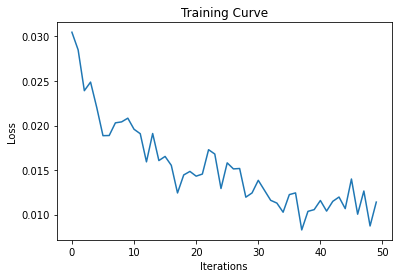

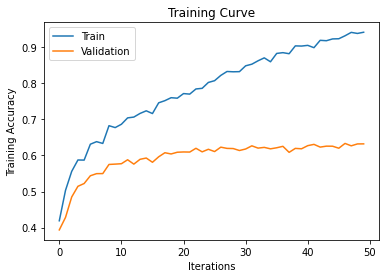

Final Training Accuracy: 0.9417930074257426
Final Validation Accuracy: 0.6321732405259087

 FOLD 2
--------------------------------
Epoch: 0 | Training Acc: 0.432416753683722 | Validation acc: 0.37577351485148514
Epoch: 1 | Training Acc: 0.4992845264338477 | Validation acc: 0.4396658415841584
Epoch: 2 | Training Acc: 0.515605058591484 | Validation acc: 0.45544554455445546
Epoch: 3 | Training Acc: 0.5706385118149824 | Validation acc: 0.4806621287128713
Epoch: 4 | Training Acc: 0.6045171520284642 | Validation acc: 0.5255259900990099
Epoch: 5 | Training Acc: 0.6174343504660247 | Validation acc: 0.5275371287128713
Epoch: 6 | Training Acc: 0.5610859728506787 | Validation acc: 0.47416460396039606
Epoch: 7 | Training Acc: 0.6026221139343312 | Validation acc: 0.5085086633663366
Epoch: 8 | Training Acc: 0.6386665119696794 | Validation acc: 0.5459467821782178
Epoch: 9 | Training Acc: 0.6477936342189736 | Validation acc: 0.5397586633663366
Epoch: 10 | Training Acc: 0.6399040878678888 | Validation

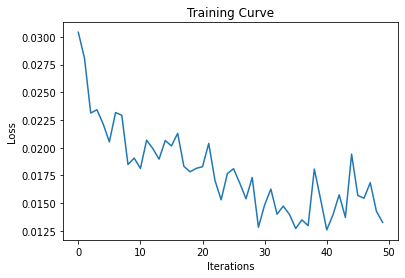

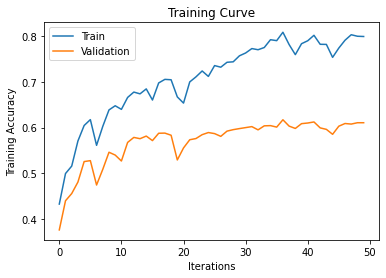

Final Training Accuracy: 0.7995513787368991
Final Validation Accuracy: 0.6106126237623762

 FOLD 3
--------------------------------
Epoch: 0 | Training Acc: 0.3859303090072321 | Validation acc: 0.31992574257425743
Epoch: 1 | Training Acc: 0.39536682523107863 | Validation acc: 0.32472153465346537
Epoch: 2 | Training Acc: 0.5169973314769695 | Validation acc: 0.4504950495049505
Epoch: 3 | Training Acc: 0.5571798739219553 | Validation acc: 0.5085086633663366
Epoch: 4 | Training Acc: 0.569362261669954 | Validation acc: 0.5157797029702971
Epoch: 5 | Training Acc: 0.5696716556445063 | Validation acc: 0.5064975247524752
Epoch: 6 | Training Acc: 0.5988707119928839 | Validation acc: 0.515934405940594
Epoch: 7 | Training Acc: 0.6162741230614533 | Validation acc: 0.536819306930693
Epoch: 8 | Training Acc: 0.6318211702827088 | Validation acc: 0.5493502475247525
Epoch: 9 | Training Acc: 0.6380477240205747 | Validation acc: 0.5450185643564357
Epoch: 10 | Training Acc: 0.6390145801910507 | Validation 

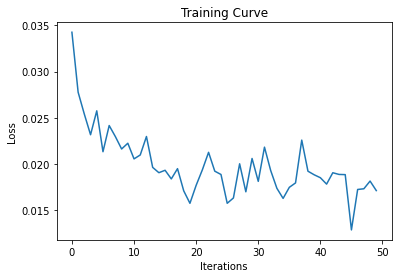

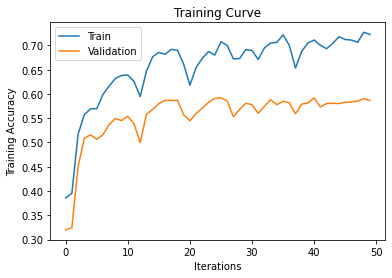

Final Training Accuracy: 0.722473604826546
Final Validation Accuracy: 0.5866336633663366

 FOLD 4
--------------------------------
Epoch: 0 | Training Acc: 0.43021232161503653 | Validation acc: 0.3728341584158416
Epoch: 1 | Training Acc: 0.4829253200293924 | Validation acc: 0.453279702970297


Exception ignored in: <function _releaseLock at 0x7f2dbbfbf8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


KeyboardInterrupt: ignored

In [38]:
if __name__ == "__main__": 
    %%time
    results = {}
    torch.manual_seed(42)
    k_folds = 5
    all_imgs, all_labels = torch.load('train_split.pth')
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # Start print
    print('--------------------------------')

    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_imgs)):

        # Print
        print('\n', f'FOLD {int(fold)+1}')
        print('--------------------------------')
        
        args = getInputArgs()
        args.nepoch = 50
        train_dl, val_dl = getDataloader(all_imgs, all_labels, train_ids, test_ids, batch_size = 128)
        mdl = EmotionClassificationNet_Better(dropout=0.25)
        mdl.apply(weight_reset) #Reset weights for proper training
        ce_loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(mdl.parameters(),weight_decay=1e-2,lr=0.001)
        #optimizer = torch.optim.Adam(mdl.parameters())
        #optimizer = torch.optim.SGD(mdl.parameters(),momentum=0.9,weight_decay=1e-7,lr=0.001)
        device = torch.device('cpu')
        iters, losses, train_acc_list, val_acc_list = [], [], [], []
        #args.val = True #Toggle validation mode
        #args.mdl = '/content/mdl_best.pth'
        if args.gpu:
            device = torch.device('cuda:0')
        if args.mdl is not None:
            mdl.load_state_dict(torch.load(args.mdl))
        mdl = mdl.to(device)
        if args.val:
            print('Val ACC loop')
            mdl.train(False)
            val_acc = calc_acc(mdl, val_dl, 'val', device)
            print('VAL ACC: ', val_acc)
        else:
            #
            # Training loop.
            best_val = -float('inf')
            for epoch in range(args.nepoch):
                #print('Train loop: ', str(epoch))
                mdl.train(True)
                mdl, avg_loss = train_loop(mdl, ce_loss, optimizer, train_dl, device)
                #mdl, avg_loss = train_loop_t(mdl, ce_loss, optimizer, train_dl, device) #Train with transform
                #print('Train ACC loop: ',str(epoch))
                mdl.train(False)
                train_acc = calc_acc(mdl, train_dl, 'train', device)
                #print('Val ACC loop: ',str(epoch))
                val_acc = calc_acc(mdl, val_dl, 'val', device)
                print('Epoch: {} | Training Acc: {} | Validation acc: {}'.format(str(epoch),train_acc,val_acc))

                #Plotting vars
                iters.append(epoch)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
                losses.append(avg_loss)
                #
                # Early stopping.
                if val_acc > best_val:
                    best_val = val_acc
                    torch.save(mdl.state_dict(), 'mdl_best.pth')
            
            #Plotting
            plt.title("Training Curve")
            plt.plot(iters, losses, label="Train")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.show()

            plt.title("Training Curve")
            plt.plot(iters, train_acc_list, label="Train")
            plt.plot(iters, val_acc_list, label="Validation")
            plt.xlabel("Iterations")
            plt.ylabel("Training Accuracy")
            plt.legend(loc='best')
            plt.show()
            
            print("Final Training Accuracy: {}".format(train_acc_list[-1]))
            print("Final Validation Accuracy: {}".format(val_acc_list[-1]))
            results[fold] = best_val

    # Print fold results
    print('\n',f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
      print(f'Fold {int(key)+1}: {value} %')
      sum += value
    print('\n',f'Average Cross-Validation Accuracy: {sum/len(results.items())} %')

#Final Training

In [ ]:
def getDataloader_full(all_imgs, all_labels, batch_size = 128):
    
    train_dataset = torch.utils.data.TensorDataset(*(all_imgs, all_labels))

    # Due to class imbalance introduce a weighted random sampler to select rare classes more often.
    weights_label = all_labels.unique(return_counts=True, sorted=True)[1].float().reciprocal()
    weights = torch.zeros_like(all_labels, dtype=torch.float)
    for idx, label in enumerate(all_labels):
        weights[idx] = weights_label[label]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    # Create the dataloaders for the different datasets.
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            num_workers=2, sampler=sampler,)

    return train_loader

Epoch: 0 | Training Acc: 0.4655796540948609
Epoch: 1 | Training Acc: 0.6018378144240587
Epoch: 2 | Training Acc: 0.6389653785464559
Epoch: 3 | Training Acc: 0.6799913369017048
Epoch: 4 | Training Acc: 0.711302249311593
Epoch: 5 | Training Acc: 0.744222022833452
Epoch: 6 | Training Acc: 0.75214256984623
Epoch: 7 | Training Acc: 0.7496983385415055
Epoch: 8 | Training Acc: 0.784041335354723
Epoch: 9 | Training Acc: 0.8076792178459825
Epoch: 10 | Training Acc: 0.8375050276909749
Epoch: 11 | Training Acc: 0.8470344358157236
Epoch: 12 | Training Acc: 0.8654435196930788
Epoch: 13 | Training Acc: 0.8745707125398348
Epoch: 14 | Training Acc: 0.8871631447046812
Epoch: 15 | Training Acc: 0.9095943813619628
Epoch: 16 | Training Acc: 0.9090993471736641
Epoch: 17 | Training Acc: 0.9145137836081805
Epoch: 18 | Training Acc: 0.9131833792271279
Epoch: 19 | Training Acc: 0.9301383001763559
Epoch: 20 | Training Acc: 0.924414467374153
Epoch: 21 | Training Acc: 0.9283128616070048
Epoch: 22 | Training Acc: 

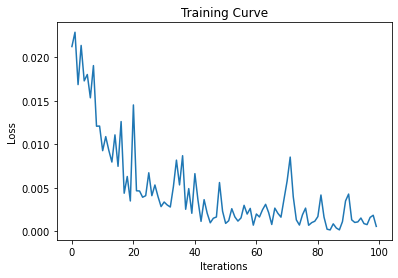

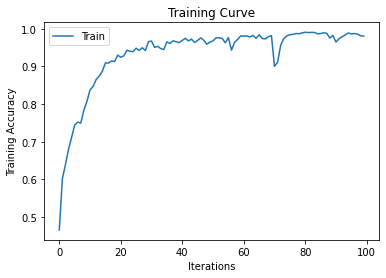

Final Training Accuracy: 0.9808174252034281


In [ ]:
if __name__ == "__main__":
    all_imgs, all_labels = torch.load('train_split.pth')
    args = getInputArgs()
    args.nepoch = 100
    train_dl = getDataloader_full(all_imgs, all_labels, batch_size = 128)
    mdl = EmotionClassificationNet_Better(dropout=0)
    mdl.apply(weight_reset) #Reset weights for proper training
    ce_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(mdl.parameters(),weight_decay=1e-4)
    device = torch.device('cpu')
    iters, losses, train_acc_list = [], [], []
    if args.gpu:
        device = torch.device('cuda:0')
    if args.mdl is not None:
        mdl.load_state_dict(torch.load(args.mdl))
    mdl = mdl.to(device)
    if args.val:
        print('Val ACC loop')
        mdl.train(False)
        val_acc = calc_acc(mdl, val_dl, 'val', device)
        print('VAL ACC: ', val_acc)
    else:
        #
        # Training loop.
        best_val = -float('inf')
        for epoch in range(args.nepoch):
            #print('Train loop: ', str(epoch))
            mdl.train(True)
            #mdl, avg_loss = train_loop(mdl, ce_loss, optimizer, train_dl, device)
            mdl, avg_loss = train_loop_t(mdl, ce_loss, optimizer, train_dl, device) #Train with transform
            #print('Train ACC loop: ',str(epoch))
            mdl.train(False)
            train_acc = calc_acc(mdl, train_dl, 'train', device)
            #print('Val ACC loop: ',str(epoch))
            print('Epoch: {} | Training Acc: {}'.format(str(epoch),train_acc))

            #Plotting vars
            iters.append(epoch)
            train_acc_list.append(train_acc)
            losses.append(avg_loss)
            #
            # Early stopping.
            if train_acc > best_val:
                best_val = train_acc
                torch.save(mdl.state_dict(), 'mdl_best.pth')
        
        #Plotting
        plt.title("Training Curve")
        plt.plot(iters, losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        plt.title("Training Curve")
        plt.plot(iters, train_acc_list, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Training Accuracy")
        plt.legend(loc='best')
        plt.show()
        
        print("Final Training Accuracy: {}".format(train_acc_list[-1]))
